In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
from pylab import figure, subplot, text, xlim, ylim, title, plot, axvline, ylabel, xlabel, legend
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

In [2]:
import os
os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']
matplotlib.rcParams['text.usetex'] = False
orig_params = pylab.rcParams.copy()
params = {'legend.fontsize': '20',
          'figure.figsize': (15, 10),
          'axes.labelsize': '20',
          'axes.titlesize':'25',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20',
          'axes.linewidth': '0.5',
          'pdf.fonttype': '42'}
pylab.rcParams.update(params)
# pylab.style.use('seaborn-white')

In [3]:
#PARAM VALS FOR THIS RUN
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_ec50_equals_median_kOn_added/k_Tf_on/samples_replicates_over_time_with_regulation_param_index_9_run_9.csv'
sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/two_way_regulation/test/samples_replicates_with_regulation_0.csv'
num_sampling_times = 24
num_cells = 20e3

updated_df = pd.read_csv(sim_file_use)
updated_df['unspliced_Target'] = updated_df['unspliced_unlabeled_Target']+updated_df['unspliced_labeled_Target']
updated_df['unspliced_TF'] = updated_df['unspliced_unlabeled_TF']+updated_df['unspliced_labeled_TF']

updated_df['labeled_Target'] = updated_df['unspliced_labeled_Target']+updated_df['spliced_labeled_Target']
updated_df['labeled_TF'] = updated_df['unspliced_labeled_TF']+updated_df['spliced_labeled_TF']

updated_df['unlabeled_Target'] = updated_df['unspliced_unlabeled_Target']+updated_df['spliced_unlabeled_Target']
updated_df['unlabeled_TF'] = updated_df['unspliced_unlabeled_TF']+updated_df['spliced_unlabeled_TF']

updated_df

,Unnamed: 0,TF_is_bursting,Target_is_bursting,TF_protein_1K,Target_protein_1K,spliced_labeled_Target,spliced_labeled_TF,spliced_unlabeled_Target,spliced_unlabeled_TF,unspliced_labeled_Target,...,k_on_TF_adjusted,total_TF_mRNA,total_Target_mRNA,sampling_time,replicate,unspliced_TF,labeled_Target,labeled_TF,unlabeled_Target,unlabeled_TF
0,0,False,True,557.150793,1101.385034,0.000000,0.0,487.727262,1.750000e+02,0.0,...,2.818288e+00,1.750000e+02,498.132514,0,0,1.017441e-05,0.000000,0.0,495.132514,1.750000e+02
1,1,False,False,447.806669,658.027100,0.000000,0.0,285.116652,1.450133e+02,0.0,...,1.733055e+00,1.450133e+02,285.116652,0,0,1.301380e-07,0.000000,0.0,285.116652,1.450133e+02
2,2,False,False,6.642168,10.923554,0.000000,0.0,0.000000,1.429480e-319,0.0,...,7.977228e-04,1.429480e-319,0.000000,0,0,0.000000e+00,0.000000,0.0,0.000000,1.429480e-319
3,3,False,False,500.120496,913.507695,0.000000,0.0,501.467674,1.555133e+02,0.0,...,2.434414e+00,1.555309e+02,501.533333,0,0,1.756873e-02,0.000000,0.0,501.533333,1.555309e+02
4,4,True,False,543.633755,1054.798003,0.000000,0.0,315.533333,2.629021e+02,0.0,...,2.732512e+00,2.639021e+02,317.533333,0,0,2.954055e-13,0.000000,0.0,315.533333,2.629021e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,True,False,506.507710,1024.900446,0.333333,0.0,553.472026,2.297084e+02,0.0,...,2.673521e+00,2.360854e+02,553.805359,1440,1,6.377079e+00,0.333333,0.0,553.472026,2.360854e+02
999996,999996,False,False,26.681020,43.956969,0.000000,0.0,0.000000,3.920000e+00,0.0,...,1.286495e-02,3.920000e+00,0.000000,1440,1,4.214380e-321,0.000000,0.0,0.000000,3.920000e+00
999997,999997,True,False,557.791059,832.276616,0.333333,0.0,451.696013,2.435942e+02,0.0,...,2.233828e+00,2.500574e+02,459.435002,1440,1,6.463259e+00,0.333333,0.0,459.101669,2.500574e+02
999998,999998,False,False,0.408773,0.364471,0.000000,0.0,0.000000,0.000000e+00,0.0,...,8.871023e-07,0.000000e+00,0.000000,1440,1,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00


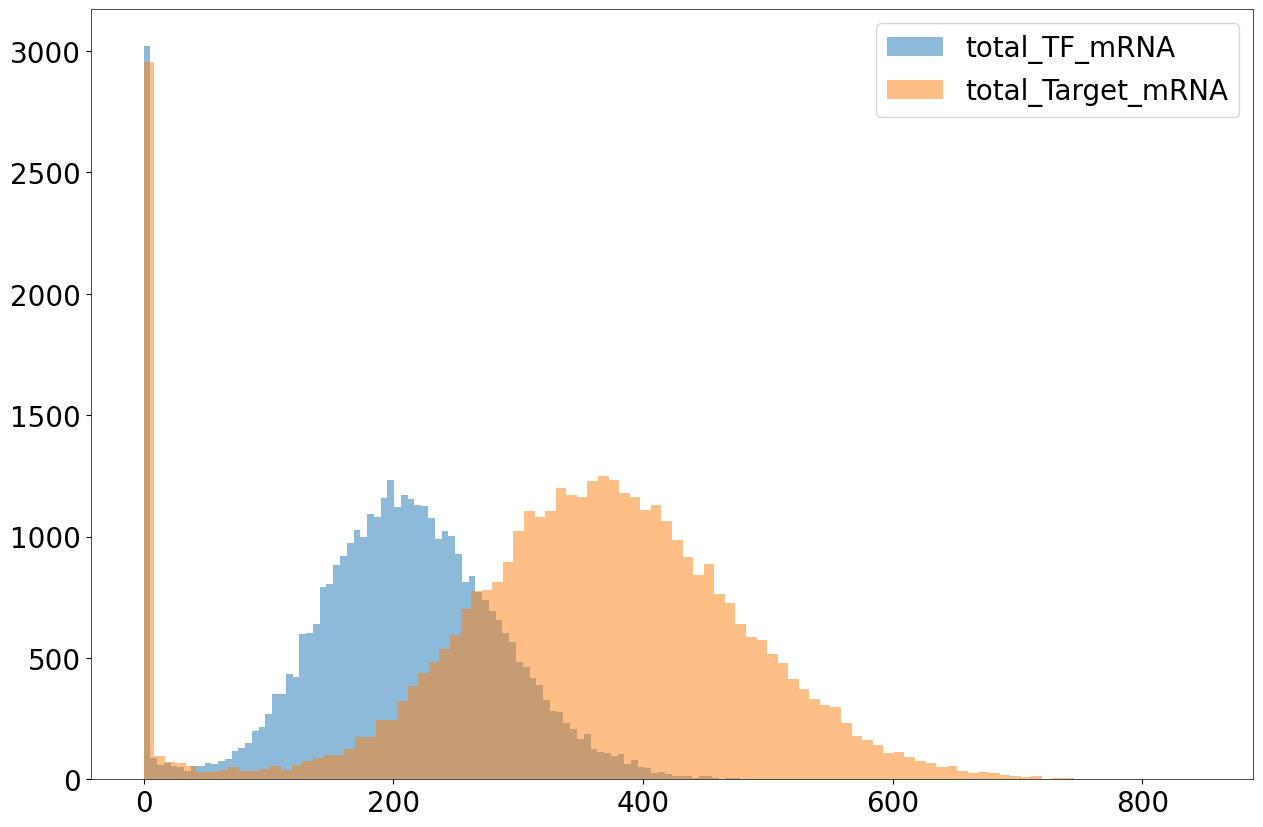

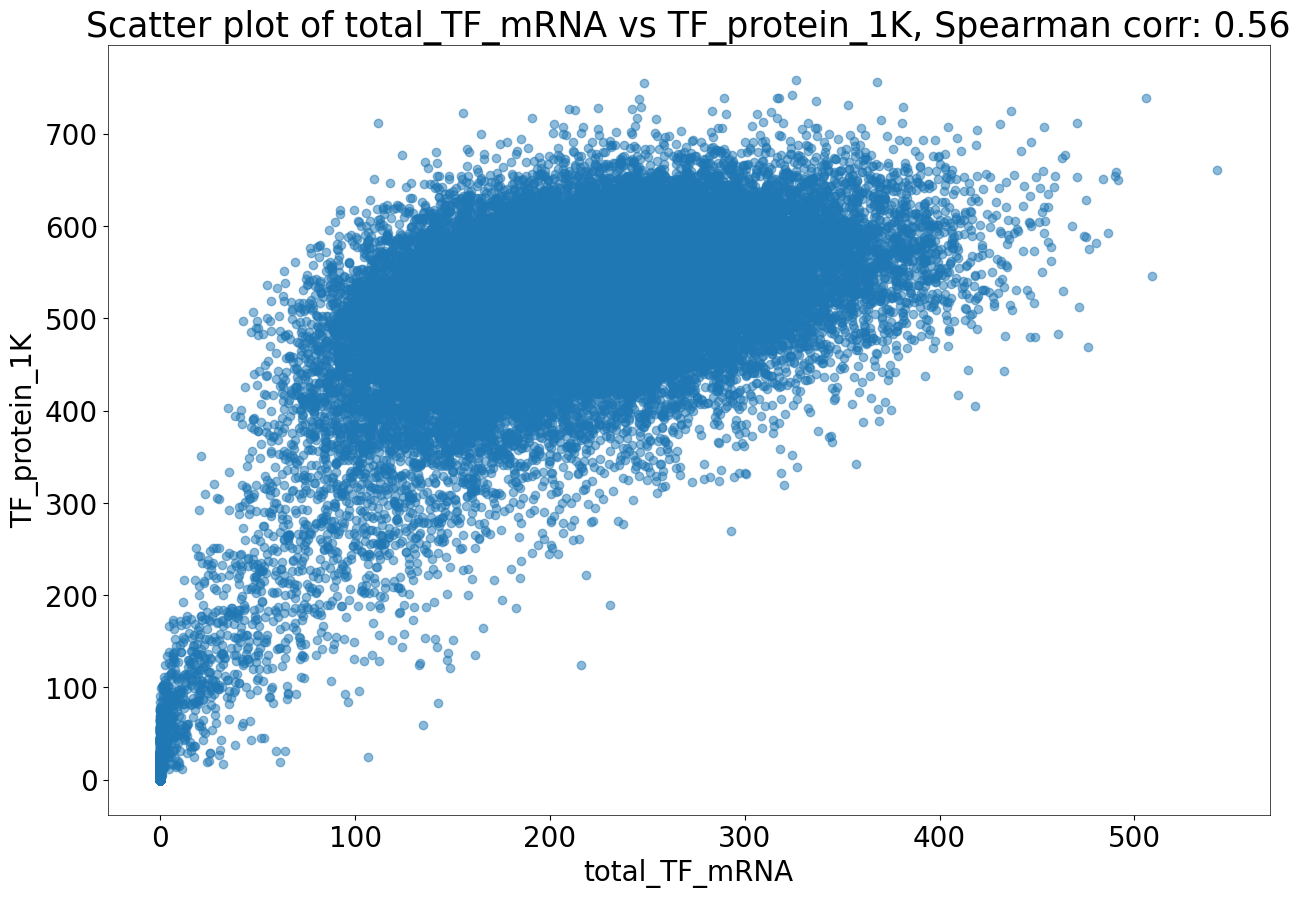

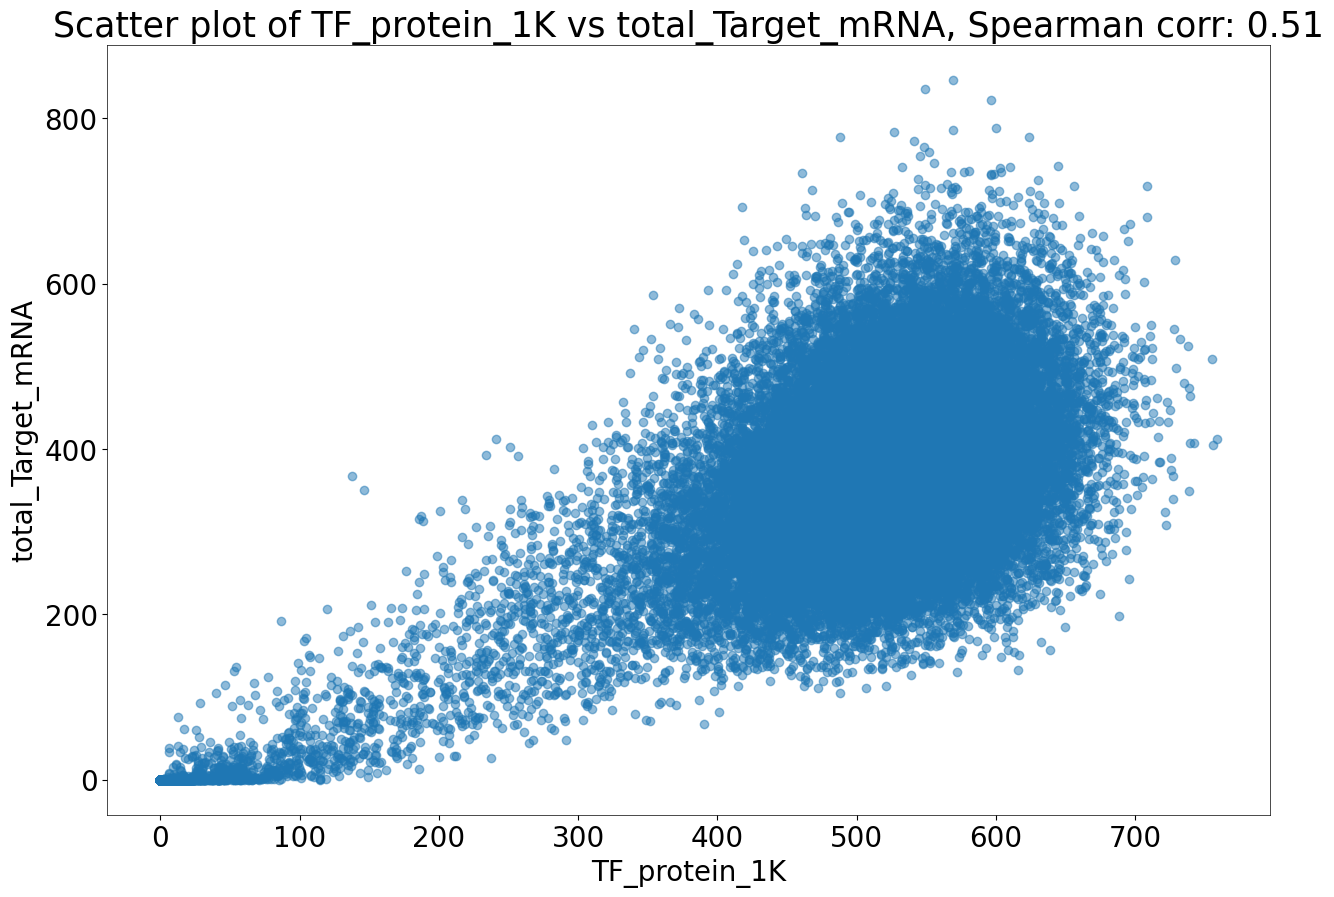

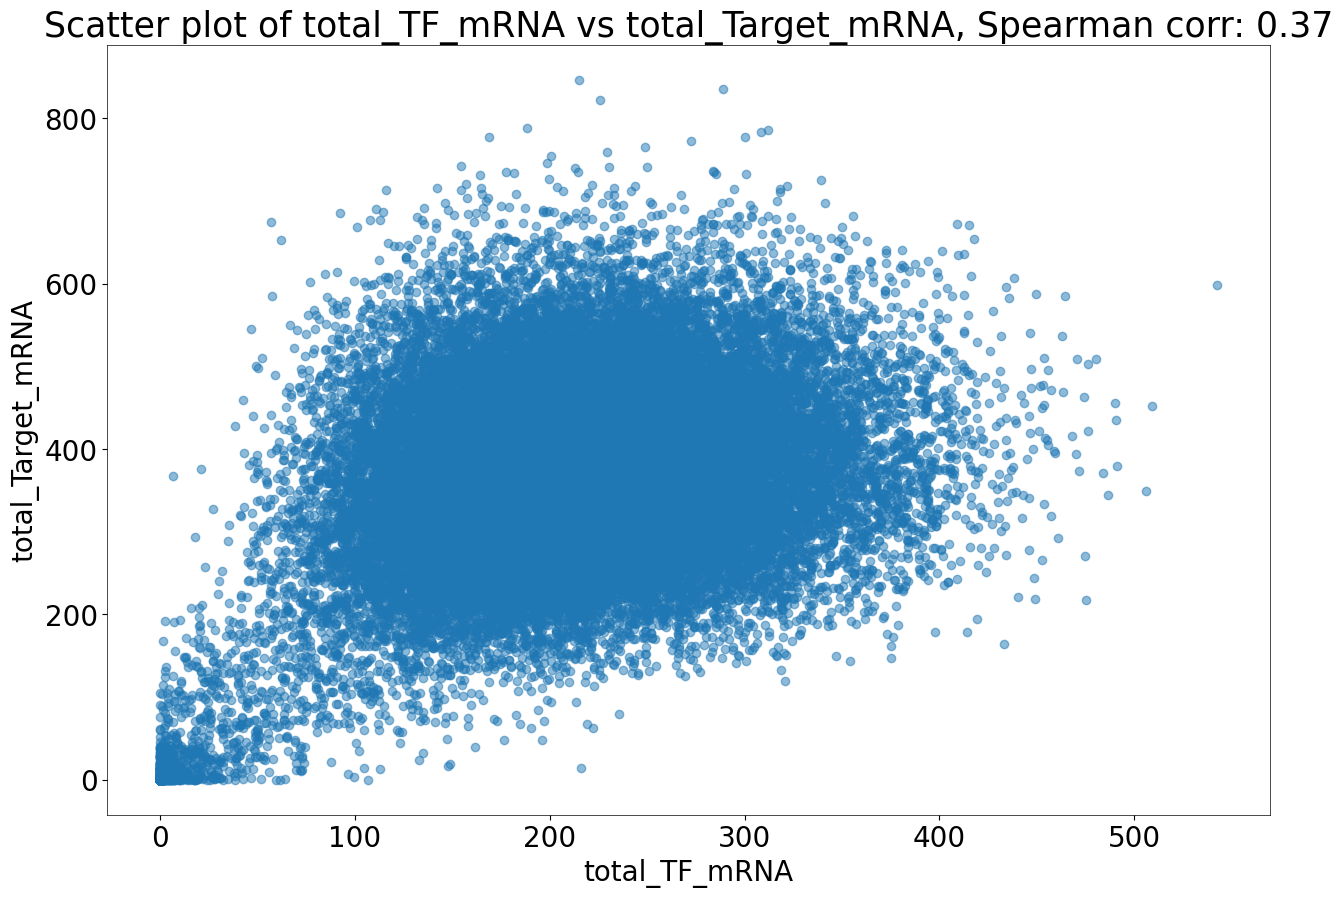

In [4]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['sampling_time'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

#Select the top and bottom 10 percentile of the TF mRNA
singleTime_df = singleTime_df.sort_values(by='total_TF_mRNA')
top_10 = singleTime_df.tail(int(len(singleTime_df)*0.1))
bottom_10 = singleTime_df.head(int(len(singleTime_df)*0.1))

#Combined top and bottom 10 percentile
combined_10 =  singleTime_df #pd.concat([top_10, bottom_10])

plt.hist((combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']), bins=100, alpha=0.5, label='total_TF_mRNA')
plt.hist(combined_10['total_Target_mRNA'], bins=100, alpha=0.5, label='total_Target_mRNA')
plt.legend(loc='upper right')
plt.show()

plt.scatter((combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']), combined_10['TF_protein_1K'], alpha=0.5)
corr = spearmanr(combined_10['TF_protein_1K'], (combined_10['spliced_unlabeled_TF'] + combined_10['spliced_labeled_TF']))
plt.ylabel('TF_protein_1K')
plt.xlabel('total_TF_mRNA')
plt.title('Scatter plot of total_TF_mRNA vs TF_protein_1K, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(combined_10['TF_protein_1K'], combined_10['total_Target_mRNA'], alpha=0.5)
corr = spearmanr(combined_10['TF_protein_1K'], combined_10['total_Target_mRNA'])
plt.xlabel('TF_protein_1K')
plt.ylabel('total_Target_mRNA')
plt.title(f'Scatter plot of TF_protein_1K vs total_Target_mRNA, Spearman corr: {corr.correlation:.2f}')
plt.show()

plt.scatter((singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']), singleTime_df['total_Target_mRNA'], alpha=0.5)
corr = spearmanr((singleTime_df['spliced_unlabeled_TF'] + singleTime_df['spliced_labeled_TF']), singleTime_df['total_Target_mRNA'])
plt.xlabel('total_TF_mRNA')
plt.ylabel('total_Target_mRNA')
plt.title(f'Scatter plot of total_TF_mRNA vs total_Target_mRNA, Spearman corr: {corr[0]:.2f}')
plt.show()

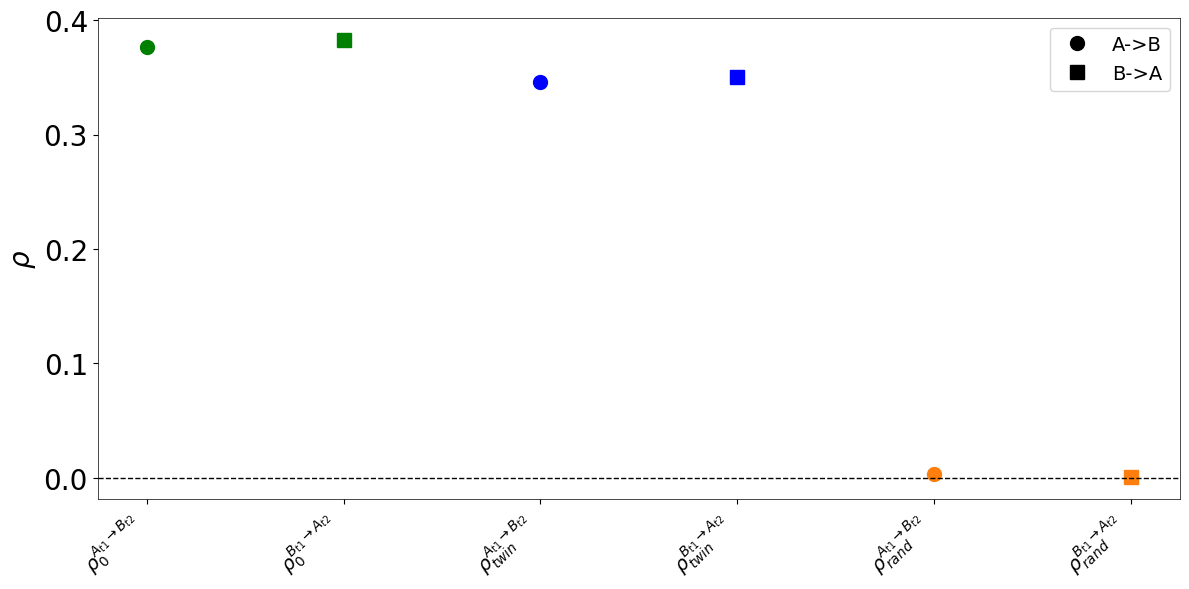

In [14]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

# --- Load simulation file ---
path_to_file = '/home/mzo5929/Keerthana/grnInference/simulationData/two_way_regulation/test/samples_replicates_with_regulation_0.csv'
sim_file = pd.read_csv(path_to_file)

# --- Extract replicates at t1 and t2 ---
t1 = 300
t2 = 600

t1_sim = sim_file[sim_file['sampling_time'] == t1].reset_index(drop=True)
t2_sim = sim_file[sim_file['sampling_time'] == t2].reset_index(drop=True)

rep0_t1 = t1_sim[t1_sim['replicate'] == 0].reset_index(drop=True)
rep1_t1 = t1_sim[t1_sim['replicate'] == 1].reset_index(drop=True)
rep0_t2 = t2_sim[t2_sim['replicate'] == 0].reset_index(drop=True)
rep1_t2 = t2_sim[t2_sim['replicate'] == 1].reset_index(drop=True)

# --- Randomly paired replicates ---
rand0_t1 = rep0_t1.sample(frac=1, random_state=0, ignore_index=True)
rand1_t1 = rep1_t1.sample(frac=1, random_state=1, ignore_index=True)
rand0_t2 = rep0_t2.sample(frac=1, random_state=2, ignore_index=True)
rand1_t2 = rep1_t2.sample(frac=1, random_state=3, ignore_index=True)

# --- Compute correlations ---
corrs = {
    r'$\rho_{0}^{A_{t1} \rightarrow B_{t2}}$': spearmanr(t1_sim['total_TF_mRNA'], t2_sim['total_Target_mRNA'])[0],
    r'$\rho_{0}^{B_{t1} \rightarrow A_{t2}}$': spearmanr(t1_sim['total_Target_mRNA'], t2_sim['total_TF_mRNA'])[0],
    r'$\rho_{twin}^{A_{t1} \rightarrow B_{t2}}$': 0.5 * (
        spearmanr(rep0_t1['total_TF_mRNA'], rep1_t2['total_Target_mRNA'])[0] +
        spearmanr(rep1_t1['total_TF_mRNA'], rep0_t2['total_Target_mRNA'])[0]
    ),
    r'$\rho_{twin}^{B_{t1} \rightarrow A_{t2}}$': 0.5 * (
        spearmanr(rep0_t1['total_Target_mRNA'], rep1_t2['total_TF_mRNA'])[0] +
        spearmanr(rep1_t1['total_Target_mRNA'], rep0_t2['total_TF_mRNA'])[0]
    ),
    r'$\rho_{rand}^{A_{t1} \rightarrow B_{t2}}$': 0.5 * (
        spearmanr(rand0_t1['total_TF_mRNA'], rand1_t2['total_Target_mRNA'])[0] +
        spearmanr(rand1_t1['total_TF_mRNA'], rand0_t2['total_Target_mRNA'])[0]
    ),
    r'$\rho_{rand}^{B_{t1} \rightarrow A_{t2}}$': 0.5 * (
        spearmanr(rand0_t1['total_Target_mRNA'], rand1_t2['total_TF_mRNA'])[0] +
        spearmanr(rand1_t1['total_Target_mRNA'], rand0_t2['total_TF_mRNA'])[0]
    )
}

# --- Plotting ---
plt.figure(figsize=(12, 6))
colors = ['green', 'green', 'blue', 'blue', '#ff7f0e', '#ff7f0e']
markers = ['o', 's', 'o', 's', 'o', 's']
x_labels = list(corrs.keys())
x_vals = np.arange(len(corrs))

for i, (label, val) in enumerate(corrs.items()):
    plt.plot(i, val, marker=markers[i], color=colors[i], markersize=10, linestyle='None')

# Format axes
plt.ylabel(r'$\rho$', fontsize=20)
plt.xticks(ticks=x_vals, labels=x_labels, rotation=45, ha='right', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.yticks(np.arange(-0.00, 0.21, 0.05), fontsize=14)
# plt.ylim(-0.01, 0.2)
plt.tight_layout()

# Legends
marker_legend = [
    Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=10, label='A->B'),
    Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=10, label='B->A')
]
plt.legend(handles=marker_legend, loc='upper right', fontsize=14)

plt.show()
